In [1]:
import sys
import importlib
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')

from __init__ import *
from __init__jupyterlab import *
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Rectangle


import collections
import itertools
import tables
#from adjustText import adjust_text

from scipy import sparse
from scipy import stats
from scipy import optimize 
import scipy.cluster.hierarchy as sch
import fbpca
# import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_clst_utils
importlib.reload(CEMBA_clst_utils)
import enhancer_gene_utils 

# config 

In [2]:
import datetime
today = datetime.date.today().strftime("%y%m%d")

output_figures = 'figures/corr_and_linked{}_{{}}'.format(today)
output_results = 'results_new/corr_and_linked{}_{{}}'.format(today)


# read data

In [3]:
f = '/cndd/Public_Datasets/CEMBA/snmCSeq/References/Annotation/gencode.vM16.annotation_genes.tsv'
df_genes = pd.read_csv(f, sep='\t')
df_genes['chrom'] = df_genes['chr'].apply(lambda x: x[3:])
df_genes = df_genes[df_genes['chrom'].isin(snmcseq_utils.get_mouse_chromosomes())]
df_genes['gid'] = df_genes['gene_id'].apply(lambda x: x.split('.')[0])
df_genes['length'] = df_genes['end'] - df_genes['start']
print(df_genes.shape)
df_genes.head()

(51772, 10)


,gene_id,gene_name,chr,start,end,strand,gene_type,chrom,gid,length
0,ENSMUSG00000102693.1,4933401J01Rik,chr1,3073253,3074322,+,TEC,1,ENSMUSG00000102693,1069
1,ENSMUSG00000064842.1,Gm26206,chr1,3102016,3102125,+,snRNA,1,ENSMUSG00000064842,109
2,ENSMUSG00000051951.5,Xkr4,chr1,3205901,3671498,-,protein_coding,1,ENSMUSG00000051951,465597
3,ENSMUSG00000102851.1,Gm18956,chr1,3252757,3253236,+,processed_pseudogene,1,ENSMUSG00000102851,479
4,ENSMUSG00000103377.1,Gm37180,chr1,3365731,3368549,-,TEC,1,ENSMUSG00000103377,2818


In [4]:
df_genes_v2 = df_genes.groupby('gene_name').first()
df_genes_v2['chrom'] = df_genes_v2['chr'].apply(lambda x: (x[3:]))
gid_to_name = df_genes.set_index('gid')['gene_name']
df_genes_v2.head()

,gene_id,chr,start,end,strand,gene_type,chrom,gid,length
gene_name,,,,,,,,,
0610005C13Rik,ENSMUSG00000109644.1,chr7,45567794,45575327,-,antisense_RNA,7,ENSMUSG00000109644,7533
0610006L08Rik,ENSMUSG00000108652.1,chr7,74818818,74853813,-,lincRNA,7,ENSMUSG00000108652,34995
0610009B22Rik,ENSMUSG00000007777.9,chr11,51685386,51688874,-,protein_coding,11,ENSMUSG00000007777,3488
0610009E02Rik,ENSMUSG00000086714.1,chr2,26445696,26459390,+,processed_transcript,2,ENSMUSG00000086714,13694
0610009L18Rik,ENSMUSG00000043644.4,chr11,120348678,120351190,+,bidirectional_promoter_lncRNA,11,ENSMUSG00000043644,2512


In [5]:
gid_to_name.head()

gid
ENSMUSG00000102693    4933401J01Rik
ENSMUSG00000064842          Gm26206
ENSMUSG00000051951             Xkr4
ENSMUSG00000102851          Gm18956
ENSMUSG00000103377          Gm37180
Name: gene_name, dtype: object

In [6]:
data_dir = '/cndd2/fangming/projects/scf_enhancers/enhancer_ethan38_200520/'

In [7]:
# list of enhancers
f = os.path.join(data_dir, 'results/enhancers.bed')
df_enhs = pd.read_csv(f, sep='\t', header=None, names=['chr', 'start', 'end', 'clsts'])
df_enhs['length'] = df_enhs['end'] - df_enhs['start']
df_enhs['index'] = df_enhs.index.values
df_enhs['chrom'] = df_enhs['chr'].apply(lambda x: x[3:]) 
print(df_enhs.shape)
df_enhs.head()

(233524, 7)


,chr,start,end,clsts,length,index,chrom
0,chr1,3083769,3083816,NaN,47,0,1
1,chr1,3112234,3112467,NaN,233,1,1
2,chr1,3112770,3112986,NaN,216,2,1
3,chr1,3113717,3114035,NaN,318,3,1
4,chr1,3118790,3118935,NaN,145,4,1


In [8]:
# list of clusters
f = os.path.join(data_dir, 'ref/annotations_order.tsv')
clst_annot = pd.read_csv(f, sep='\t').set_index('cluster')['annotation']
print(clst_annot.shape)
clst_annot.head()

(38,)


cluster
1-1-1       L4/5 IT (1)
1-2-1       L4/5 IT (2)
1-2-2       L4/5 IT (3)
2-1-1    L6 CT Cpa6 (1)
2-1-2    L6 CT Cpa6 (2)
Name: annotation, dtype: object

### get features 

In [9]:
# global mC levels
import pickle as pkl

fs = [
    os.path.join(data_dir, 'results/cluster_global_mcg_round2.pkl'),
    os.path.join(data_dir, 'results/cluster_global_mcg_round3.pkl'),
]
global_mean_mcg = []
for f in fs:
    with open(f, 'rb') as fh:
        global_mean_mcg.append(pkl.load(fh))
global_mean_mcg = pd.concat(global_mean_mcg) 


fs = [
    os.path.join(data_dir, 'results/cluster_global_mch_round2.pkl'),
    os.path.join(data_dir, 'results/cluster_global_mch_round3.pkl'),
]
global_mean_mch = []
for f in fs:
    with open(f, 'rb') as fh:
        global_mean_mch.append(pkl.load(fh))
global_mean_mch = pd.concat(global_mean_mch)
    
print(global_mean_mcg.shape, global_mean_mch.shape)
global_mean_mcg.head()

(82,) (82,)


1-1     0.773445
1-2     0.774822
10-1    0.833052
2-1     0.787654
2-2     0.804645
dtype: float64

## 4 matrices 

In [10]:
# gene rna
f = os.path.join(data_dir, 'results/gene_counts_10x_cells_v3_ethan38.tsv')
gene_rna_clsts = pd.read_csv(f, sep='\t', index_col=0)
nclsts = gene_rna_clsts.shape[1]
print(gene_rna_clsts.shape)

# remove genes with coverage in less than half of clusters
cov_mat = (gene_rna_clsts > 50)
gene_conds = (cov_mat.sum(axis=1) > int(nclsts*0.5))
clsts_conds = (cov_mat.sum(axis=0) > 1000) # coverage in more than 1000 genes 
gene_rna_clsts = gene_rna_clsts.loc[gene_conds, clsts_conds]
print(gene_rna_clsts.shape)

# logcpm normalization

# gene_lengths = df_genes.set_index('gid').reindex(gene_rna_clsts.index)['length'].dropna()
# gene_lengths = gene_lengths.fillna(np.nanmean(gene_lengths))
# gene_rna_clsts = snmcseq_utils.logcpm(gene_rna_clsts.loc[gene_lengths.index])
gene_rna_clsts = snmcseq_utils.logcpm(gene_rna_clsts) # this should be the same

print(gene_rna_clsts.shape)
gene_rna_clsts.head()

(31053, 39)
(12209, 38)
(12209, 38)


,1-1-1,1-2-1,1-2-2,2-1-1,2-1-2,2-2-1,2-3-1,2-3-2,2-3-3,3-1-1,...,6-4-2,6-5,7-1-1,7-1-2,7-2-1,7-2-2,8-1-1,8-2-1,9-1-1,9-2-1
ENSMUSG00000051951,2.792765,2.884245,2.972553,2.990215,3.003085,3.012648,2.787964,2.921068,2.790798,2.832214,...,3.176078,2.885463,2.806340,2.781266,3.133454,3.155324,2.971140,2.995801,2.623001,2.308281
ENSMUSG00000089699,1.235995,1.275134,1.358576,1.418035,1.413086,1.417832,1.261069,1.350110,1.257992,1.239016,...,1.597122,1.290723,1.283675,1.258057,1.547861,1.583148,1.476768,1.422698,0.897863,0.549188
ENSMUSG00000033845,1.276457,1.256878,1.278312,1.303170,1.310829,1.264980,1.335077,1.317336,1.302930,1.289687,...,1.306078,1.355222,1.323851,1.379514,1.293317,1.337522,1.199024,1.274772,1.204373,1.489434
ENSMUSG00000104217,1.086046,0.997441,1.010606,1.079471,1.080625,1.043694,1.049231,1.101286,1.061872,1.029398,...,1.035723,0.991323,1.063883,1.156064,1.102540,1.121192,1.051361,1.120664,0.690411,1.166152
ENSMUSG00000033813,1.299530,1.255670,1.255693,1.286266,1.272271,1.260215,1.247543,1.307498,1.436605,1.232380,...,1.324598,1.277651,1.307155,1.434994,1.337652,1.381731,1.136631,1.269849,1.243293,1.302359


In [11]:
# gene mch
f = os.path.join(data_dir, 'results/gene_counts_mch_mch_ethan38.tsv')
mc_table = pd.read_csv(f, sep='\t', index_col=0)
f = os.path.join(data_dir, 'results/gene_counts_mch_ch_ethan38.tsv')
c_table = pd.read_csv(f, sep='\t', index_col=0)
nclsts = c_table.shape[1]
print(mc_table.shape, c_table.shape)
mc_table.head()

# remove low coverage genes
# remove low coverage clusters
base_call_cutoff = 1e3
_cov_mat = (c_table >= base_call_cutoff)
clst_cond = (_cov_mat.sum(axis=0) > 1000) # more than 1000 genes are covered in that cell type
gene_cond = (_cov_mat.sum(axis=1) > int(0.5*nclsts)) # more than half of the clusters are covered the gene
gene_mch_c_clsts = c_table.loc[gene_cond, clst_cond]
gene_mch_mc_clsts = mc_table.loc[gene_cond, clst_cond]
print(gene_mch_c_clsts.shape)
print(gene_mch_mc_clsts.shape)

# get mcc
gene_mch_clsts = snmcseq_utils.get_mcc_lite_v2(gene_mch_c_clsts, gene_mch_mc_clsts, base_call_cutoff=base_call_cutoff)
gene_mch_clsts = gene_mch_clsts.divide(global_mean_mch.loc[gene_mch_clsts.columns.values], axis=1)

del gene_mch_c_clsts, gene_mch_mc_clsts
print(gene_mch_clsts.shape)
gene_mch_clsts.head()

(55487, 39) (55487, 39)
(39556, 38)
(39556, 38)
(39556, 38)


,1-1-1,1-2-1,1-2-2,2-1-1,2-1-2,2-2-1,2-3-1,2-3-2,2-3-3,3-1-1,...,6-4-2,6-5,7-1-1,7-1-2,7-2-1,7-2-2,8-1-1,8-2-1,9-1-1,9-2-1
ENSMUSG00000102693,1.044560,1.388850,1.814953,0.986151,1.137234,1.012576,1.489216,1.085170,1.015275,0.949874,...,1.104607,0.967632,1.201295,1.261993,1.113230,1.147272,1.132247,0.968678,0.981316,1.029372
ENSMUSG00000051951,0.585127,0.492982,0.405509,0.509483,0.519171,0.479962,0.664061,0.627431,0.781421,0.512411,...,0.586042,0.690053,0.667905,0.556561,0.483934,0.468551,0.328460,0.373701,0.910935,0.810503
ENSMUSG00000103377,0.626740,0.512025,0.425547,0.587109,0.574752,0.596842,0.727876,0.910802,0.896544,0.597430,...,0.356648,0.690416,1.573784,1.312456,1.371550,1.124712,0.397388,0.388527,0.711115,1.022159
ENSMUSG00000104017,0.579676,0.462759,0.387327,0.721597,0.792361,0.671177,0.811555,0.614899,1.093287,0.622296,...,0.800520,1.044661,0.616798,0.747225,0.624706,0.871620,0.515409,0.319068,0.868590,0.659482
ENSMUSG00000103025,0.642186,0.546094,0.462418,0.621182,0.532478,0.493473,0.720957,0.623816,0.906200,0.649551,...,0.865781,0.871531,0.760678,0.574916,0.697269,0.578430,0.290371,0.488555,0.966604,0.771126


In [12]:
# enhancer mcg
f = os.path.join(data_dir, 'results/enhancer_cluster_mcg.tsv')
mc_table = pd.read_csv(f, sep='\t', index_col=[0, 1, 2], dtype={'chr': str})
f = os.path.join(data_dir, 'results/enhancer_cluster_cg.tsv')
c_table = pd.read_csv(f, sep='\t', index_col=[0, 1, 2], dtype={'chr': str})
nclsts = c_table.shape[1]
print(mc_table.shape, c_table.shape)
mc_table.head()

# remove low coverage enhs
# remove low coverage clusters
base_call_cutoff = 20
_cov_mat = (c_table >= base_call_cutoff)
clst_cond = (_cov_mat.sum(axis=0) > 1000) # more than 1000 enhs are covered in that cell type
enh_cond = (_cov_mat.sum(axis=1) > int(0.5*nclsts)) # more than half of the clusters are covered the enh
enh_mcg_c_clsts = c_table.loc[enh_cond, clst_cond]
enh_mcg_mc_clsts = mc_table.loc[enh_cond, clst_cond]
print(enh_mcg_c_clsts.shape, enh_mcg_mc_clsts.shape)

# get mcc
enh_mcg_clsts = snmcseq_utils.get_mcc_lite_v2(enh_mcg_c_clsts, enh_mcg_mc_clsts, base_call_cutoff=base_call_cutoff)
enh_mcg_clsts = enh_mcg_clsts.divide(global_mean_mcg.loc[enh_mcg_clsts.columns.values], axis=1)
print(enh_mcg_clsts.shape)

# index
enh_mcg_clsts.index = df_enhs.set_index(['chrom', 'start', 'end']).reindex(enh_mcg_clsts.index)['index']
print(enh_mcg_clsts.shape)

del enh_mcg_c_clsts, enh_mcg_mc_clsts

print(enh_mcg_clsts.shape)
enh_mcg_clsts.head()

(233514, 38) (233514, 38)
(155652, 38) (155652, 38)
(155652, 38)
(155652, 38)
(155652, 38)


,1-1-1,1-2-1,1-2-2,2-1-1,2-1-2,2-2-1,2-3-1,2-3-2,2-3-3,3-1-1,...,6-4-2,6-5,7-1-1,7-1-2,7-2-1,7-2-2,8-1-1,8-2-1,9-1-1,9-2-1
index,,,,,,,,,,,,,,,,,,,,,
1,1.240298,1.248431,1.241011,1.220681,1.233649,1.222340,1.227358,1.252849,1.130344,1.236917,...,1.102198,1.160278,1.164447,1.169190,1.153231,1.196036,1.175057,1.143372,1.240520,1.135905
3,0.732653,0.633566,0.699519,0.218281,0.211427,0.147583,0.313127,0.743879,0.689585,0.351170,...,0.366996,0.998848,0.952729,0.937336,0.649250,0.966029,0.656137,0.643699,0.692691,0.589149
4,0.117538,0.072983,0.046292,0.948267,0.853397,1.017745,1.093087,0.636395,0.645230,1.020415,...,0.629163,1.210724,0.604933,1.053982,0.607489,0.607537,0.613934,0.602296,0.648136,0.648404
5,0.021914,0.000000,0.000000,0.027021,0.072489,0.071764,0.158069,0.186484,0.189072,0.184250,...,0.184364,0.180213,0.893183,0.572816,0.178013,0.178027,0.179902,0.176491,0.189924,0.190003
6,0.472017,0.397952,0.432056,0.264584,0.156398,0.253389,0.361300,0.298297,0.380712,0.356650,...,0.371232,0.362874,0.356935,0.536903,0.358444,0.358471,0.362246,0.355379,0.382427,0.382585


In [13]:
# enhancer atac
f = os.path.join(data_dir, 'results/enhancer_cluster_atac.tsv')
enh_atac_clsts = pd.read_csv(f, sep='\t', index_col=[0, 1, 2])
print(enh_atac_clsts.shape)
enh_atac_clsts.head()

nclsts = enh_atac_clsts.shape[1]
print(enh_atac_clsts.shape)

# remove enhs with coverage in less than half of clusters
# remove clusters with low coverage
cov_mat = (enh_atac_clsts > 0)
enh_conds = (cov_mat.sum(axis=1) > int(nclsts*0.5))
clsts_conds = (cov_mat.sum(axis=0) > 1000) # coverage in more than 10000 enhs 
enh_atac_clsts = enh_atac_clsts.loc[enh_conds, clsts_conds]
print(enh_atac_clsts.shape)

# logtpm normalization
enh_lengths = df_enhs.copy()
enh_lengths['start'] = df_enhs['start'] - 1000
enh_lengths['end'] = df_enhs['end'] + 1000
enh_lengths['length'] = df_enhs['length'] + 2*1000 # 1kb flanking
enh_lengths = enh_lengths.set_index(['chr', 'start', 'end']).reindex(enh_atac_clsts.index) 

enh_atac_clsts = snmcseq_utils.logtpm(enh_atac_clsts, enh_lengths['length'])
enh_atac_clsts.index = enh_lengths['index']
print(enh_atac_clsts.shape)
enh_atac_clsts.head()

(233524, 38)
(233524, 38)
(225713, 38)
(225713, 38)


,1-1-1,1-2-1,1-2-2,2-1-1,2-1-2,2-2-1,2-3-1,2-3-2,2-3-3,3-1-1,...,6-4-2,6-5,7-1-1,7-1-2,7-2-1,7-2-2,8-1-1,8-2-1,9-1-1,9-2-1
index,,,,,,,,,,,,,,,,,,,,,
0,0.130886,0.119725,0.000000,0.096849,0.192041,0.084071,0.000000,0.000000,0.000000,0.110173,...,0.564528,0.608619,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.164258,0.0
1,0.099659,0.047817,0.000000,0.227126,0.214111,0.077658,0.181955,0.809963,0.000000,0.101991,...,0.629618,0.000000,0.433551,0.000000,0.000000,0.000000,0.000000,0.0,0.152714,0.0
2,0.239656,0.246094,0.000000,0.454261,0.484983,0.590365,0.491015,1.079025,0.000000,0.470720,...,0.879333,0.000000,0.435650,0.706488,0.411634,0.000000,0.746975,0.0,0.523153,0.0
3,0.262038,0.278067,0.000000,0.458675,0.489559,0.617380,0.477878,0.796291,0.000000,0.470562,...,0.862421,0.000000,0.000000,0.690856,0.399770,0.000000,0.730996,0.0,0.481399,0.0
4,1.205729,1.191456,1.167327,1.167571,1.150293,1.174013,1.042267,0.000000,1.252377,1.045489,...,0.643045,0.295275,0.996498,0.865335,0.808972,0.971425,1.182083,0.0,0.473350,0.0


# subset to variable

In [14]:
# most variable genes
gene_var = gene_rna_clsts.std(axis=1)
var_genes = gene_var > np.percentile(gene_var, 70)

In [15]:
np.sum(var_genes)

3663

### Shared enhancers, shared genes, shared clusters, and nan check

In [16]:
print(gene_rna_clsts.shape)
print(gene_mch_clsts.shape)
print(enh_mcg_clsts.shape)
print(enh_atac_clsts.shape)

shared_genes = np.intersect1d(gene_rna_clsts.index.values, gene_mch_clsts.index.values)
shared_enhs = np.intersect1d(enh_mcg_clsts.index.values, enh_atac_clsts.index.values) 
shared_clusters = np.array(list(set(gene_rna_clsts.columns.tolist())
                              & set(gene_mch_clsts.columns.tolist())
                              & set(enh_mcg_clsts.columns.tolist())
                              & set(enh_atac_clsts.columns.tolist())
                        ))
print(shared_genes.shape, shared_enhs.shape, shared_clusters.shape)
print(shared_genes[:2])
print(shared_enhs[:2])
print(shared_clusters[:2])


(12209, 38)
(39556, 38)
(155652, 38)
(225713, 38)
(12137,) (152104,) (38,)
['ENSMUSG00000000001' 'ENSMUSG00000000056']
[1 3]
['4-2-3' '6-2-1']


In [17]:
gene_rna_clsts = gene_rna_clsts.loc[shared_genes, shared_clusters]
gene_mch_clsts = gene_mch_clsts.loc[shared_genes, shared_clusters]
enh_mcg_clsts = enh_mcg_clsts.loc[shared_enhs, shared_clusters]
enh_atac_clsts = enh_atac_clsts.loc[shared_enhs, shared_clusters]
print(gene_rna_clsts.shape)
print(gene_mch_clsts.shape)
print(enh_mcg_clsts.shape)
print(enh_atac_clsts.shape)

(12137, 38)
(12137, 38)
(152104, 38)
(152104, 38)


In [18]:
print(gene_rna_clsts.isnull().sum().sum())
print(gene_mch_clsts.isnull().sum().sum())
print(enh_mcg_clsts.isnull().sum().sum())
print(enh_atac_clsts.isnull().sum().sum())

0
0
0
0


### Get nearest gene info for each region

In [19]:
f = os.path.join(data_dir, 'results/enhancer_nearest_genes.bed')
regions_info = pd.read_csv(f, sep='\t', header=None, dtype={0: str, 4: str})
regions_info.head()

# regions_info = regions_info.iloc[:, [0,1,2,8,9,11]] 
regions_info = regions_info.iloc[:, [0,1,2,7,8,9,10,11]] 
regions_info.columns = ['chr', 'start', 'end', 'transcript_id', 'transcript_name', 'gene_id', 'gene_name', 'distance']
regions_info = pd.merge(regions_info, df_enhs, on=['chr', 'start', 'end']).sort_values('index')
# regions_info = regions_info.groupby('index').first().reset_index()

print(regions_info.shape)
regions_info.head()

(233524, 12)


,chr,start,end,transcript_id,transcript_name,gene_id,gene_name,distance,clsts,length,index,chrom
0,chr1,3083769,3083816,ENSMUST00000193812.1,4933401J01Rik-201,ENSMUSG00000102693.1,4933401J01Rik,10516,NaN,47,0,1
1,chr1,3112234,3112467,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,10218,NaN,233,1,1
2,chr1,3112770,3112986,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,10754,NaN,216,2,1
3,chr1,3113717,3114035,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,11701,NaN,318,3,1
4,chr1,3118790,3118935,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,16774,NaN,145,4,1


## Correlation  

#### Length of enhancers 

FileNotFoundError: [Errno 2] No such file or directory: 'figures/corr_and_linked201026_Enhancer length distribution.png'

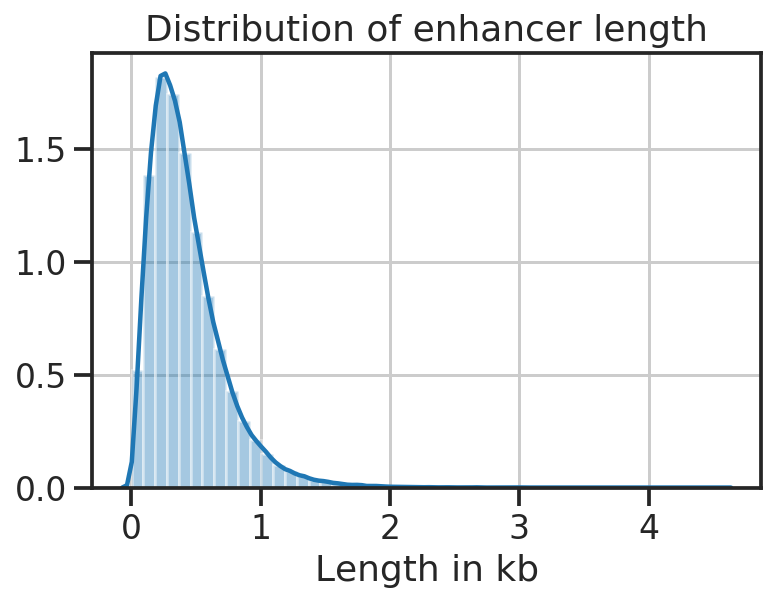

In [20]:
lens = df_enhs.loc[shared_enhs, 'length']
fig, ax = plt.subplots()
sns.distplot(lens.values/1000, ax=ax)
ax.set_xlabel('Length in kb')
ax.set_title('Distribution of enhancer length')
output_name = 'Enhancer length distribution' 
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
plt.show()

In [ ]:
# full correlation

# gene 
_x_features = shared_genes 
_X = gene_rna_clsts.values
# # enhancer
_y_features = shared_enhs
_Y = enh_mcg_clsts.values 

# # enhancer
_y2_features = shared_enhs
_Y2 = enh_atac_clsts.values 
print(_X.shape, _Y.shape, _Y2.shape)

# row genes_list 
def get_tss(row):
    if row['strand'] == '+':
        return row['start']
    elif row['strand'] == '-':
        return row['end']
genes_list = df_genes.set_index('gid').reindex(shared_genes).reset_index().copy()
genes_list['chrom'] = genes_list['chr'].apply(lambda x: x[len('chr'):])
genes_list['tss'] = genes_list.apply(get_tss, axis=1)

# row ens_list
ens_list = df_enhs.set_index('index').loc[shared_enhs].reset_index()
ens_list['center'] = ens_list[['start', 'end']].mean(axis=1).astype(int)

print(ens_list.shape, genes_list.shape)
genes_list.head()

In [ ]:
_X_ranks = snmcseq_utils.rank_rows(_X)
_Y_ranks = snmcseq_utils.rank_rows(_Y)
_Y2_ranks = snmcseq_utils.rank_rows(_Y2)

In [ ]:
# this should be imported from a list
# more than 15 mins for ~500,000 enhancers

# tss and enhancer center: 500KB ~ 2KB
# to_evals - ens, gene, val, dist

KB = 1000
window_size = 2000*KB # (+/- 1Mb)
inner_window_size = 4*KB #(+/- 2kb)

ti = time.time()
# ens, gene
toeval_genes = []
toeval_enhs = []
toeval_dists = []
toeval_isingenebody = []

for idx, gene in genes_list.iterrows():
    if idx % 1000 == 0:
        print(idx, time.time()-ti)
    
    chrom, pos, start, end = gene['chrom'], gene['tss'], gene['start'], gene['end']
    if chrom in ['Y']:
        continue
    chrom_size = snmcseq_utils.get_chrom_lengths_mouse().loc[chrom]
    window = [max(0, pos-window_size/2), 
              min(chrom_size, pos+window_size/2)]
    window_exclude = [max(0, pos-inner_window_size/2),
                      min(chrom_size, pos+inner_window_size/2)
                     ]
    in_gene = [start, end]

    # get ens
    pos_enh = ens_list['center'] 
    cond = ((ens_list['chrom'] == chrom) 
             & (pos_enh >= window[0]) 
             & (pos_enh <= window[1])
             & ((pos_enh <= window_exclude[0]) | (pos_enh >= window_exclude[1]))
            )
    in_gene = ((ens_list['chrom'] == chrom) 
             & (pos_enh >= in_gene[0]) 
             & (pos_enh <= in_gene[1])
              )
    ens_include = ens_list[cond]['index'].values
    in_gene = in_gene[cond].values
    dist = np.abs(ens_list[cond]['center'] - pos)
    
    toeval_genes.append([gene['gid']]*len(ens_include))
    toeval_enhs.append(ens_include)
    toeval_dists.append(dist)
    toeval_isingenebody.append(in_gene)
    
#     if idx > 10:
#         break
        


In [ ]:
to_evals = pd.DataFrame(np.array([
                np.hstack(toeval_genes),
                np.hstack(toeval_enhs),
                np.hstack(toeval_dists),
                np.hstack(toeval_isingenebody),
                ]).T, columns=['gene', 'enh', 'dist', 'is_in_genebody'])

print(to_evals.shape)
to_evals.head()

In [ ]:
# save 4 matrices
"""

genes
enhancers
pairs

clusters

gene_clst_rna
gene_clst_mch
enhancer_clst_mcg
enhancer_clst_atac
"""


to_save = [
    genes_list, # genes
    ens_list,
    to_evals[['gene', 'enh', 'dist', 'is_in_genebody']],
    
    shared_clusters,
    
    gene_rna_clsts,
    gene_mch_clsts,
    enh_mcg_clsts,
    enh_atac_clsts,
]

for i in to_save:
    print(i.shape)
    


In [ ]:
import pickle

to_save_filename = '/sphere/fangming/enhancers/scripts/data_organized/enhancer_gene_analysis_processed_data_201026.pkl'
with open(to_save_filename, 'wb') as fh:
    pickle.dump(to_save, fh)
    